## Evaluating instances of proxy discrimination in insurance
### Data Science and AI Risk Management Industry Group

### 0. Loading Libraries, Data, and Feature Encoding

In [138]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import shap

Loading the telematics dataset

In [139]:
data = pd.read_csv("../data/telematics_syn-032021.csv")
data.head()

Duration  Insured.age Insured.sex  Car.age  Marital  Car.use  Credit.score  \
0       366           45        Male       -1  Married  Commute         609.0   
1       182           44      Female        3  Married  Commute         575.0   
2       184           48      Female        6  Married  Commute         847.0   
3       183           71        Male        6  Married  Private         842.0   
4       183           84        Male       10  Married  Private         856.0   

  Region  Annual.miles.drive  Years.noclaims  ...  Left.turn.intensity10  \
0  Urban             6213.71              25  ...                    1.0   
1  Urban            12427.42              20  ...                   58.0   
2  Urban            12427.42              14  ...                    0.0   
3  Urban             6213.71              43  ...                    0.0   
4  Urban             6213.71              65  ...                    2.0   

   Left.turn.intensity11  Left.turn.intensity12  Right.turn.intensity08  \
0                    0.0                    0.0                     3.0   
1                   24.0                   11.0                  1099.0   
2                    0.0                    0.0                     0.0   
3                    0.0                    0.0                     0.0   
4                    0.0                    0.0                   325.0   

   Right.turn.intensity09  Right.turn.intensity10  Right.turn.intensity11  \
0                     1.0                     0.0                     0.0   
1                   615.0                   219.0                   101.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                   111.0                    18.0                     4.0   

   Right.turn.intensity12  NB_Claim    AMT_Claim  
0                     0.0         1  5100.171753  
1                    40.0         1   883.554840  
2                     0.0         0     0.000000  
3                     0.0         0     0.000000  
4                     2.0         0     0.000000  

[5 rows x 52 columns]

Dummy encoding the dataset for better classification model performance in predicting.

In [140]:
data = pd.get_dummies(data, drop_first=True)
data.head()

Duration  Insured.age  Car.age  Credit.score  Annual.miles.drive  \
0       366           45       -1         609.0             6213.71   
1       182           44        3         575.0            12427.42   
2       184           48        6         847.0            12427.42   
3       183           71        6         842.0             6213.71   
4       183           84       10         856.0             6213.71   

   Years.noclaims  Territory  Annual.pct.driven  Total.miles.driven  \
0              25         70           0.849315         8864.376247   
1              20         26           0.465753         8092.308208   
2              14         84           0.520548         3225.832512   
3              43         30           0.065753          253.024528   
4              65         70           0.441096         4374.379634   

   Pct.drive.mon  ...  Right.turn.intensity11  Right.turn.intensity12  \
0       0.148070  ...                     0.0                     0.0   
1       0.147686  ...                   101.0                    40.0   
2       0.153735  ...                     0.0                     0.0   
3       0.106702  ...                     0.0                     0.0   
4       0.123807  ...                     4.0                     2.0   

   NB_Claim    AMT_Claim  Insured.sex_Male  Marital_Single  Car.use_Commute  \
0         1  5100.171753                 1               0                1   
1         1   883.554840                 0               0                1   
2         0     0.000000                 0               0                1   
3         0     0.000000                 1               0                0   
4         0     0.000000                 1               0                0   

   Car.use_Farmer  Car.use_Private  Region_Urban  
0               0                0             1  
1               0                0             1  
2               0                0             1  
3               0                1             1  
4               0                1             1  

[5 rows x 54 columns]

Checking the statistical metrics of the dataset

In [141]:
data.describe()

Duration    Insured.age        Car.age   Credit.score  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      314.204060      51.378950       5.639720     800.888870   
std        79.746222      15.467075       4.062135      83.382316   
min        27.000000      16.000000      -2.000000     422.000000   
25%       200.000000      39.000000       2.000000     766.000000   
50%       365.000000      51.000000       5.000000     825.000000   
75%       366.000000      63.000000       8.000000     856.000000   
max       366.000000     103.000000      20.000000     900.000000   

       Annual.miles.drive  Years.noclaims      Territory  Annual.pct.driven  \
count       100000.000000   100000.000000  100000.000000      100000.000000   
mean          9124.122908       28.839960      56.531390           0.502294   
std           3826.144730       16.123717      24.036518           0.299189   
min              0.000000        0.000000      11.000000           0.002740   
25%           6213.710000       15.000000      35.000000           0.249315   
50%           7456.452000       29.000000      62.000000           0.490411   
75%          12427.420000       41.000000      78.000000           0.753425   
max          56731.172300       79.000000      91.000000           1.000000   

       Total.miles.driven  Pct.drive.mon  ...  Right.turn.intensity11  \
count       100000.000000  100000.000000  ...           100000.000000   
mean          4833.575303       0.139365  ...              246.713120   
std           4545.943016       0.042807  ...             8977.569994   
min              0.095298       0.000000  ...                0.000000   
25%           1529.897500       0.120894  ...                0.000000   
50%           3468.287765       0.137909  ...                2.000000   
75%           6779.876842       0.155203  ...               27.000000   
max          47282.603936       0.998172  ...           841176.000000   

       Right.turn.intensity12      NB_Claim      AMT_Claim  Insured.sex_Male  \
count           100000.000000  100000.00000  100000.000000     100000.000000   
mean               198.753690       0.04494     137.602253          0.539430   
std               8585.177049       0.21813    1264.320056          0.498445   
min                  0.000000       0.00000       0.000000          0.000000   
25%                  0.000000       0.00000       0.000000          0.000000   
50%                  0.000000       0.00000       0.000000          1.000000   
75%                  9.000000       0.00000       0.000000          1.000000   
max             841144.000000       3.00000  104074.886700          1.000000   

       Marital_Single  Car.use_Commute  Car.use_Farmer  Car.use_Private  \
count   100000.000000    100000.000000   100000.000000    100000.000000   
mean         0.300700         0.498150        0.014130         0.461290   
std          0.458565         0.499999        0.118027         0.498502   
min          0.000000         0.000000        0.000000         0.000000   
25%          0.000000         0.000000        0.000000         0.000000   
50%          0.000000         0.000000        0.000000         0.000000   
75%          1.000000         1.000000        0.000000         1.000000   
max          1.000000         1.000000        1.000000         1.000000   

        Region_Urban  
count  100000.000000  
mean        0.781410  
std         0.413292  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

[8 rows x 54 columns]

Since all values are in the format integer, ensuring type throughtout as same. 

In [142]:
data = data.astype('int')

Splitting the dataset in between train and test sets. We are trying to predict the gender of the policyholder based on other demographic factors of each policyholder.

In [143]:
y = data["Insured.sex_Male"]
X = data.drop(["Insured.sex_Male"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

Further, we begin modelling and generating predictions. 

The models we fit are as follows:
    1. Random Forest
    2. Logotic Regression
    3. Lasso-Logistic Regression
    4. XGBoost
    5. ANN (Artificial Neural Networks) [Just fiited the model and generated predictions]

Process Pipeline for each model:

1. Fitting the model and checking for stability of teh model based on 5 different sample folds
2. Predicting results
3. Accuracy of the predictions
4.Feature importance of each variable
5. Partial dependence plot for each variable. (for functionlaity testing, just have used the first variable (Duration))
6. Understaning each predict in detail Using LIME. (for functionlaity testing, just have used the 50th policholder)
7. Understaning each predict in detail Using SHAP. (for functionlaity testing, just have used the 50th policholder)

### 1. Model Building and Explaining Predictions 

#### 1.1 RANDOM FOREST

In [144]:
rf_model = RandomForestClassifier(n_estimators=1000, n_jobs=12)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15, n_jobs=12)

In [145]:
# Performing cross-validation with 5 folds
scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Calculating mean and standard deviation of cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

print(f"Mean accuracy: {mean_score:.2f}")
print(f"Standard deviation: {std_score:.2f}")

Mean accuracy: 0.77
Standard deviation: 0.00


In [146]:
y_pred = rf_model.predict(X_test)

In [147]:
cm = confusion_matrix(y_test, y_pred)

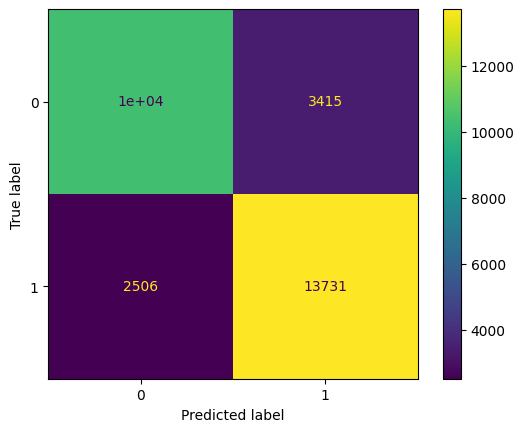

In [148]:
ConfusionMatrixDisplay(cm).plot()

In [149]:
print(str((accuracy_score(y_test, y_pred) * 100)))

80.26333333333334


In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     13763
           1       0.80      0.85      0.82     16237

    accuracy                           0.80     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.80      0.80      0.80     30000



In [151]:
features = X_train.columns
importance = rf_model.feature_importances_
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

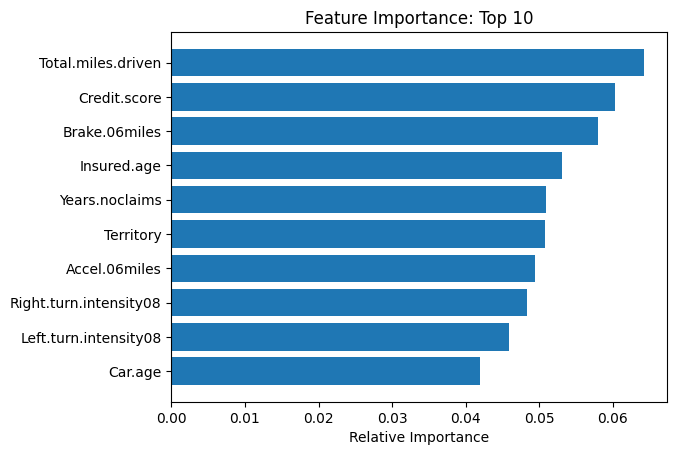

In [152]:
plt.title("Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

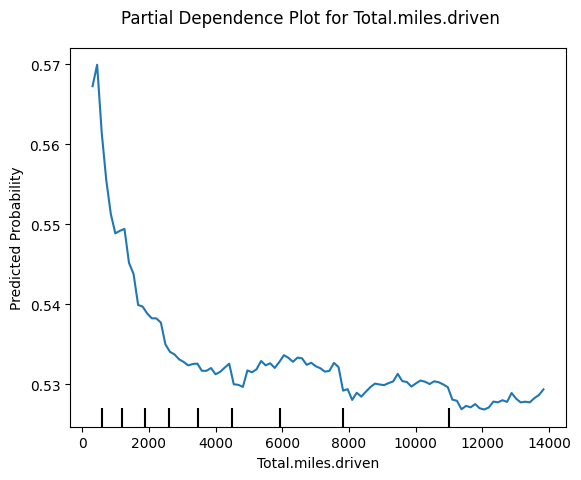

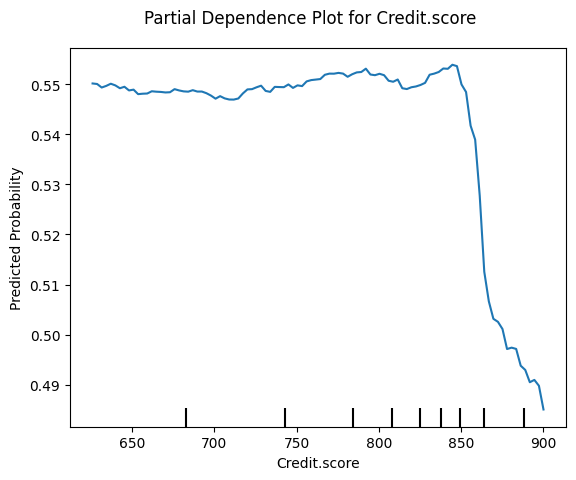

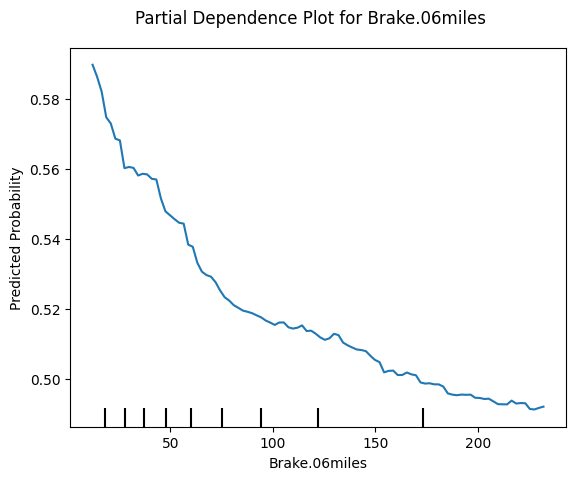

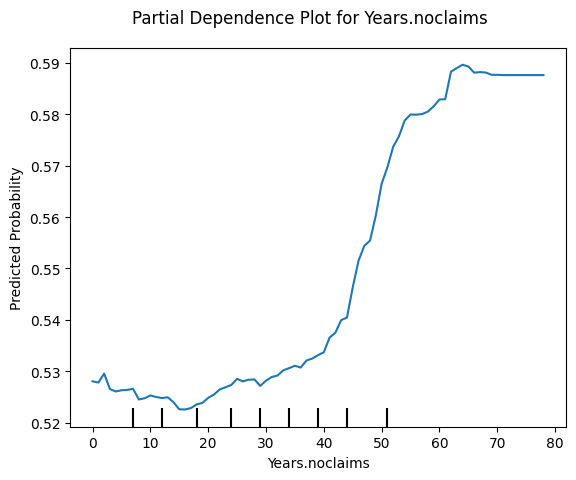

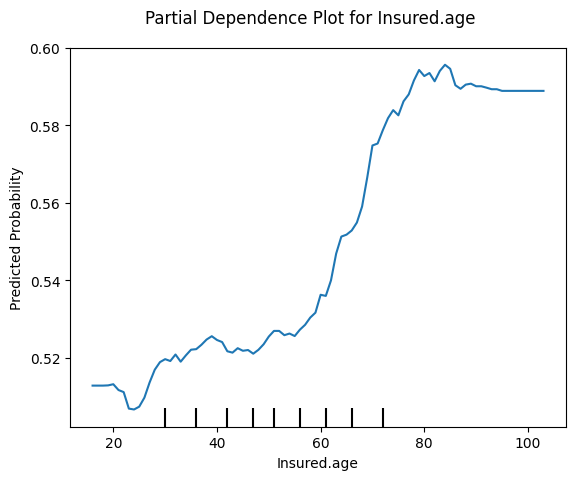

In [153]:
variable = 'Total.miles.driven'

PartialDependenceDisplay.from_estimator(rf_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Credit.score'

PartialDependenceDisplay.from_estimator(rf_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Brake.06miles'

PartialDependenceDisplay.from_estimator(rf_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Years.noclaims'

PartialDependenceDisplay.from_estimator(rf_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Insured.age'

PartialDependenceDisplay.from_estimator(rf_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

In [154]:
#Choosen to explain the 50th entry
choosen_instance = X_test.iloc[[50]]

In [155]:
#Creating the Explainer
predict_model = lambda x: rf_model.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=['Female','Male'],mode='classification')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


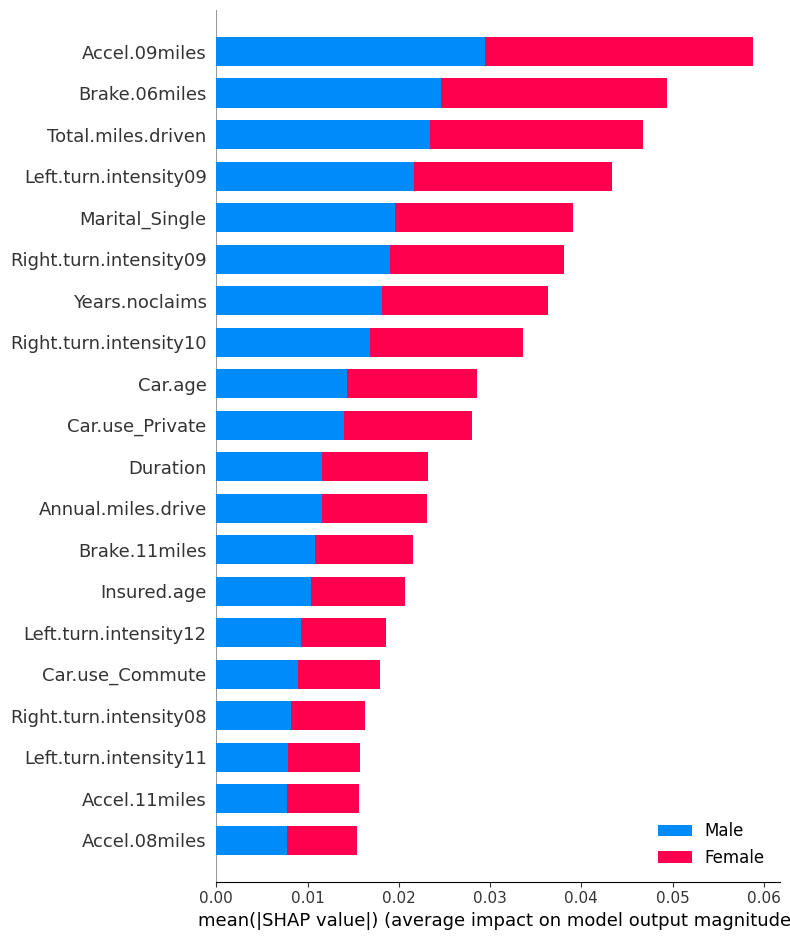

In [156]:
explainer = shap.TreeExplainer(rf_model,masker=shap.maskers.Impute(data=X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar",class_names=['Female','Male'])

#### 2. LOGISTIC REGRESSION

In [157]:
lr_model =  LogisticRegression(solver='liblinear', random_state = 0, max_iter = 500)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=0, solver='liblinear')

In [158]:
# Performing cross-validation with 5 folds
scores = cross_val_score(lr_model, X_train, y_train, cv=5)

# Calculating mean and standard deviation of cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

print(f"Mean accuracy: {mean_score:.2f}")
print(f"Standard deviation: {std_score:.2f}")

Mean accuracy: 0.57
Standard deviation: 0.00


In [159]:
y_pred = lr_model.predict(X_test)

In [160]:
cm = confusion_matrix(y_test, y_pred)

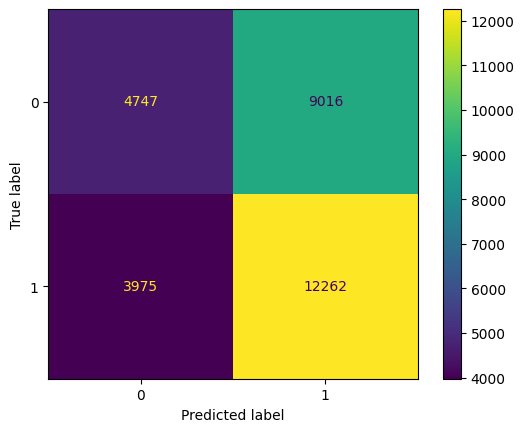

In [161]:
ConfusionMatrixDisplay(cm).plot()

In [162]:
print(str((accuracy_score(y_test, y_pred) * 100)))

56.69666666666666


In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.34      0.42     13763
           1       0.58      0.76      0.65     16237

    accuracy                           0.57     30000
   macro avg       0.56      0.55      0.54     30000
weighted avg       0.56      0.57      0.55     30000



In [164]:
features = X_train.columns
importance = lr_model.coef_[0]
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

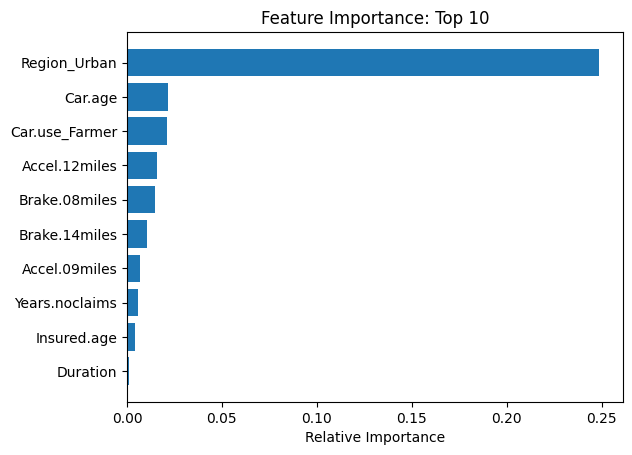

In [165]:
plt.title("Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

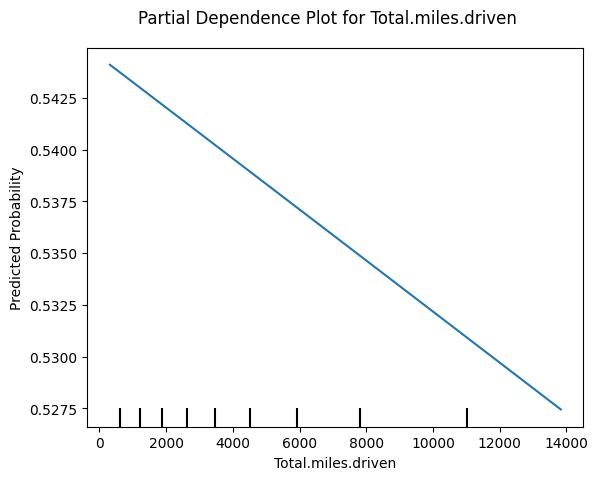

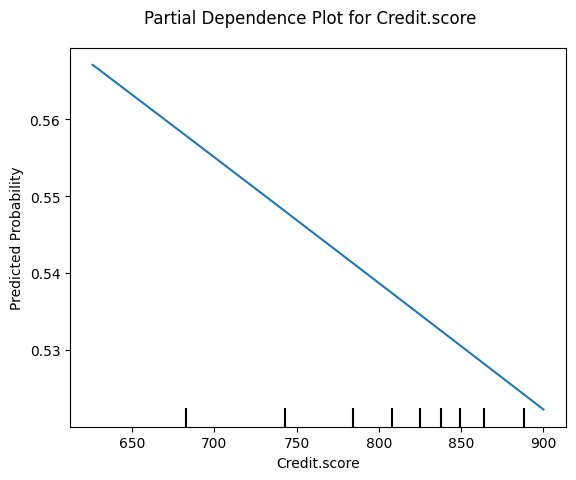

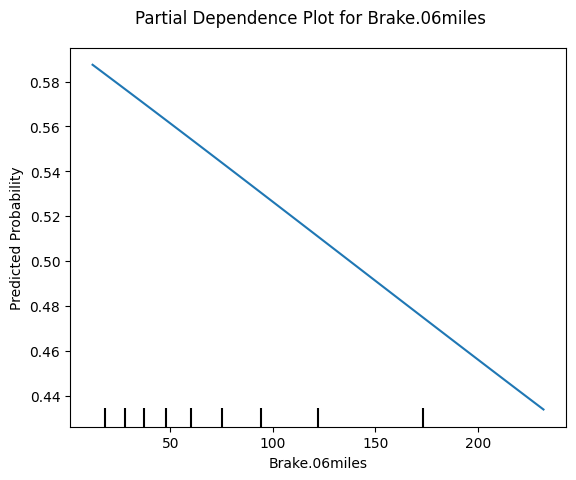

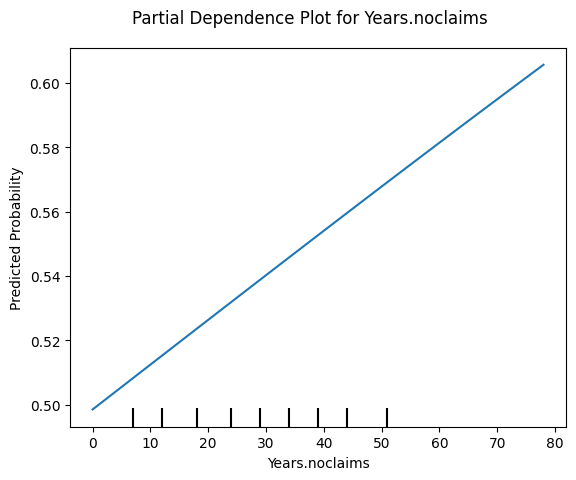

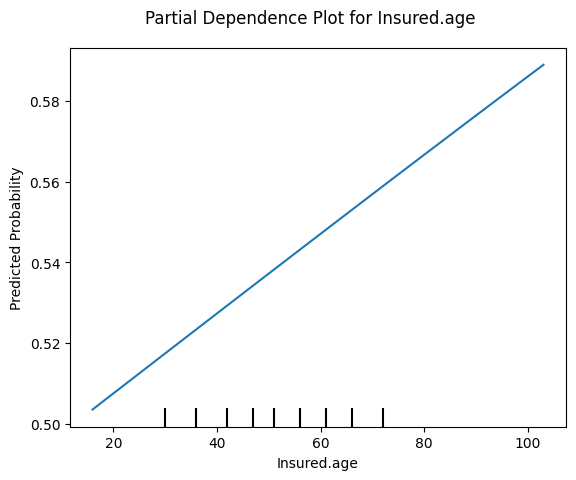

In [166]:
variable = 'Total.miles.driven'

PartialDependenceDisplay.from_estimator(lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Credit.score'

PartialDependenceDisplay.from_estimator(lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Brake.06miles'

PartialDependenceDisplay.from_estimator(lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Years.noclaims'

PartialDependenceDisplay.from_estimator(lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Insured.age'

PartialDependenceDisplay.from_estimator(lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

In [167]:
#Choosen to explain the 50th entry
choosen_instance = X_test.iloc[[50]]

In [168]:
#Creating the Explainer
predict_model = lambda x: lr_model.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=['Female','Male'],mode='classification')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but LogisticRegression was fitted with feature names


Estimating transforms: 100%|██████████| 1000/1000 [00:04<00:00, 226.81it/s]


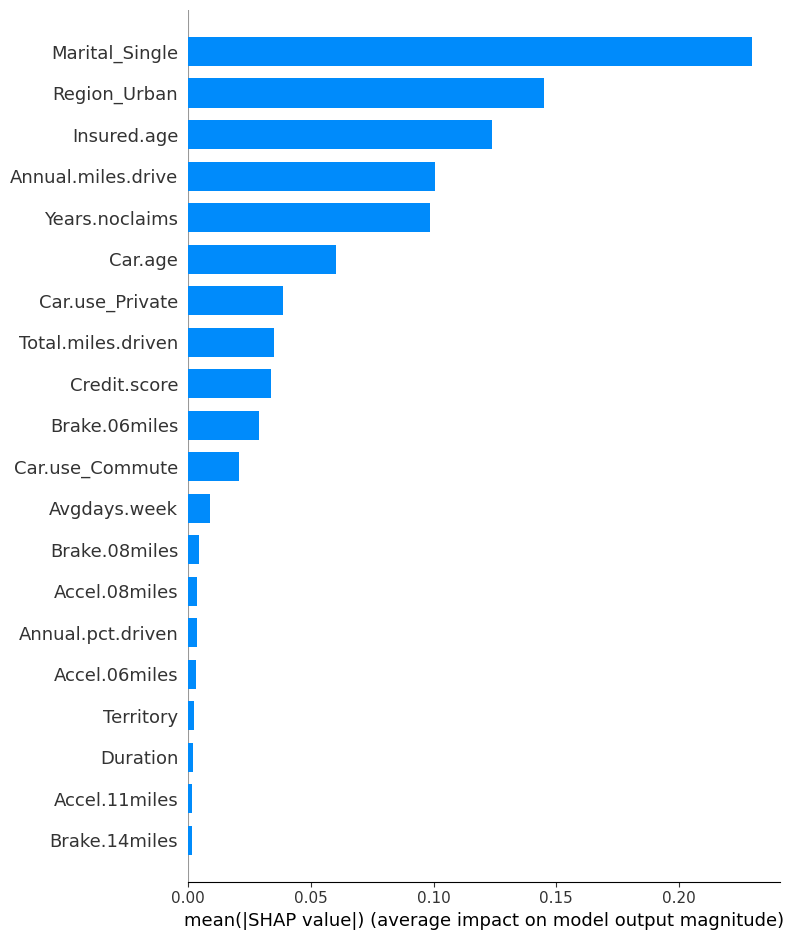

In [169]:
explainer = shap.LinearExplainer(lr_model,masker=shap.maskers.Impute(data=X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar",class_names=['Female','Male'])

#### 3. Lasso Regression

In [170]:
Lasso_lr_model =  LogisticRegression(penalty='l1', solver='liblinear',max_iter=500)
Lasso_lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')

In [171]:
# Performing cross-validation with 5 folds
scores = cross_val_score(Lasso_lr_model, X_train, y_train, cv=5)

# Calculating mean and standard deviation of cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

print(f"Mean accuracy: {mean_score:.2f}")
print(f"Standard deviation: {std_score:.2f}")

Mean accuracy: 0.57
Standard deviation: 0.00


In [172]:
y_pred = Lasso_lr_model.predict(X_test)

In [173]:
cm = confusion_matrix(y_test, y_pred)

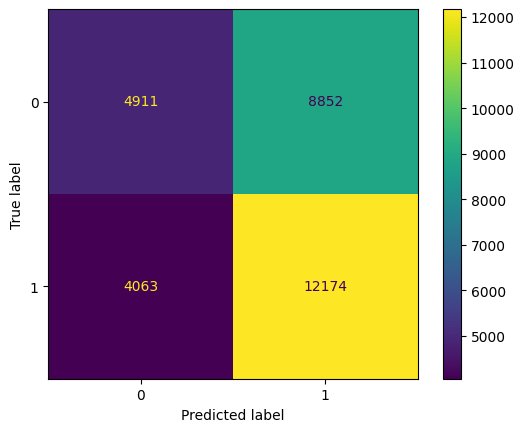

In [174]:
ConfusionMatrixDisplay(cm).plot()

In [175]:
print(str((accuracy_score(y_test, y_pred) * 100)))

56.95


In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.36      0.43     13763
           1       0.58      0.75      0.65     16237

    accuracy                           0.57     30000
   macro avg       0.56      0.55      0.54     30000
weighted avg       0.56      0.57      0.55     30000



In [177]:
features = X_train.columns
importance = Lasso_lr_model.coef_[0]
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

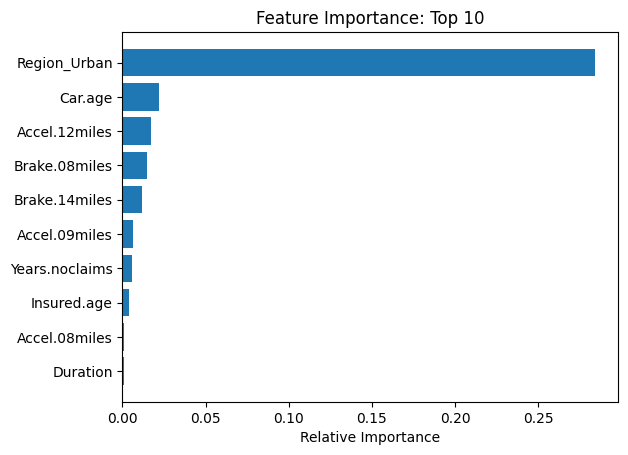

In [178]:
plt.title("Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

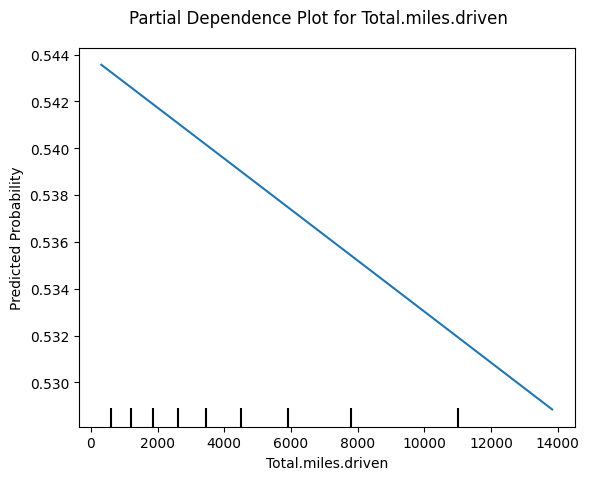

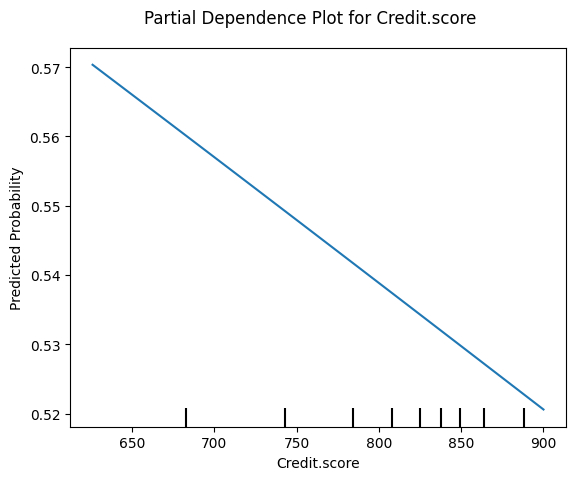

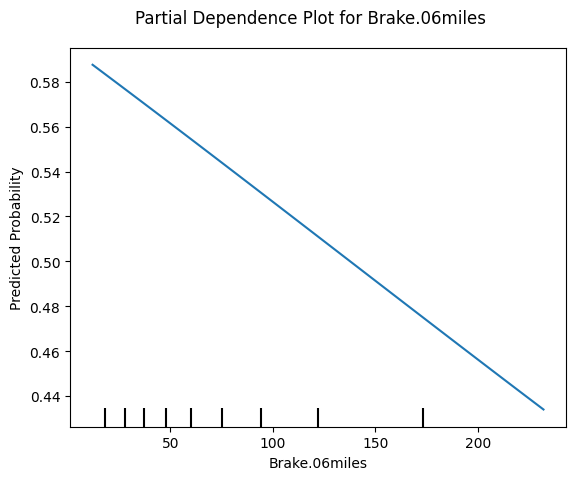

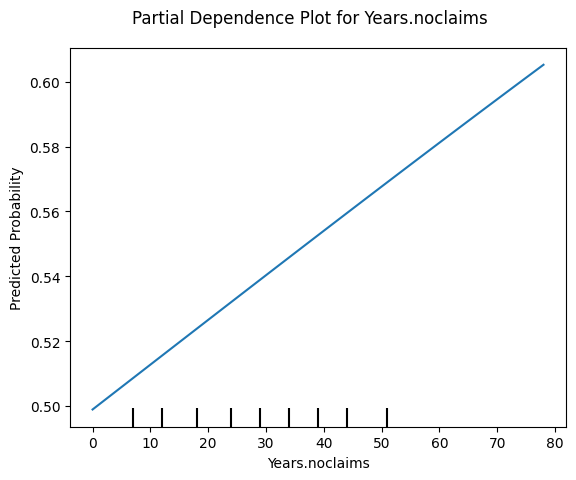

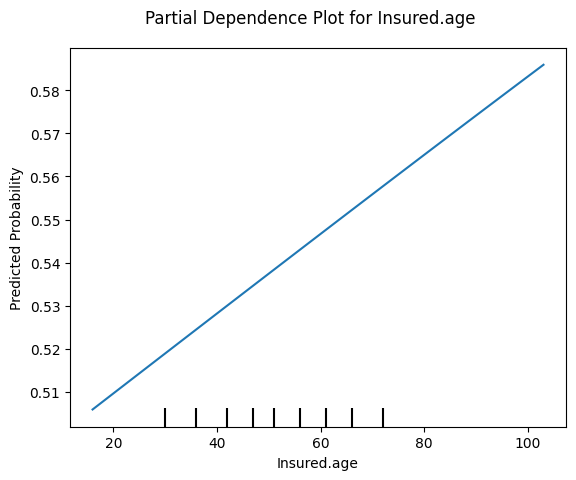

In [179]:
variable = 'Total.miles.driven'

PartialDependenceDisplay.from_estimator(Lasso_lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Credit.score'

PartialDependenceDisplay.from_estimator(Lasso_lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Brake.06miles'

PartialDependenceDisplay.from_estimator(Lasso_lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Years.noclaims'

PartialDependenceDisplay.from_estimator(Lasso_lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Insured.age'

PartialDependenceDisplay.from_estimator(Lasso_lr_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

In [180]:
#Choosen to explain the 50th entry
choosen_instance = X_test.iloc[[50]]

In [181]:
#Creating the Explainer
predict_model = lambda x: Lasso_lr_model.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=['Female','Male'],mode='classification')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but LogisticRegression was fitted with feature names


Estimating transforms: 100%|██████████| 1000/1000 [00:02<00:00, 359.86it/s]


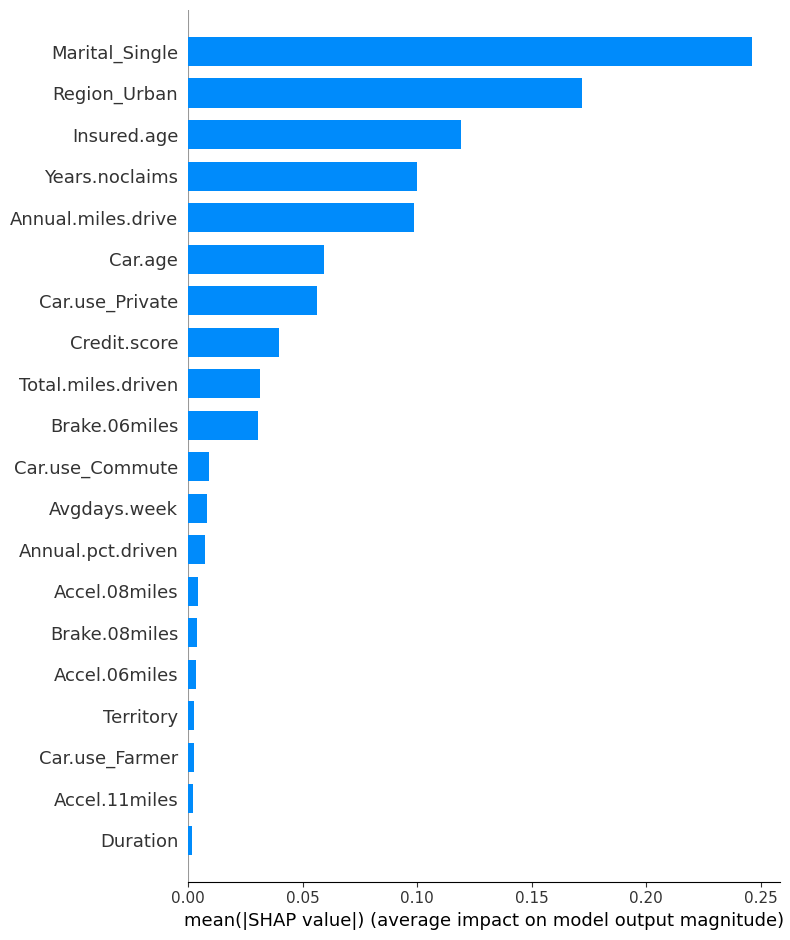

In [182]:
explainer = shap.LinearExplainer(Lasso_lr_model,masker=shap.maskers.Impute(data=X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar",class_names=['Female','Male'])

#### 4. XGBOOST

In [183]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, n_jobs=12)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [184]:
# Performing cross-validation with 5 folds
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)

# Calculating mean and standard deviation of cross-validation scores
mean_score = scores.mean()
std_score = scores.std()

print(f"Mean accuracy: {mean_score:.2f}")
print(f"Standard deviation: {std_score:.2f}")

Mean accuracy: 0.68
Standard deviation: 0.00


In [185]:
y_pred = xgb_model.predict(X_test)

In [186]:
cm = confusion_matrix(y_test, y_pred)

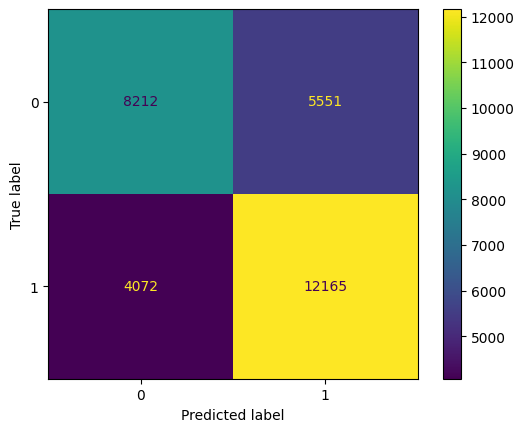

In [187]:
ConfusionMatrixDisplay(cm).plot()

In [188]:
print(str((accuracy_score(y_test, y_pred) * 100)))

67.92333333333333


In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63     13763
           1       0.69      0.75      0.72     16237

    accuracy                           0.68     30000
   macro avg       0.68      0.67      0.67     30000
weighted avg       0.68      0.68      0.68     30000



In [190]:
features = X_train.columns
importance = xgb_model.feature_importances_
ind_top = np.argsort(importance)[len(features)-10:]
ind_bottom = np.argsort(importance)[:10]

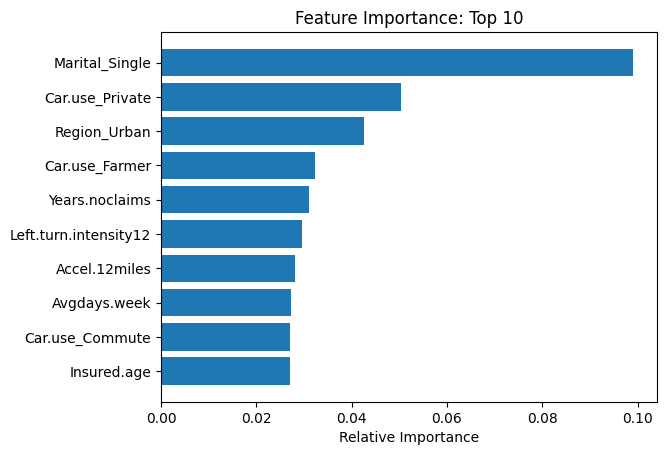

In [191]:
plt.title("Feature Importance: Top 10")
plt.barh(range(len(ind_top)), importance[ind_top], align="center")
plt.yticks(range(len(ind_top)), [features[i] for i in ind_top])
plt.xlabel("Relative Importance")
plt.show()

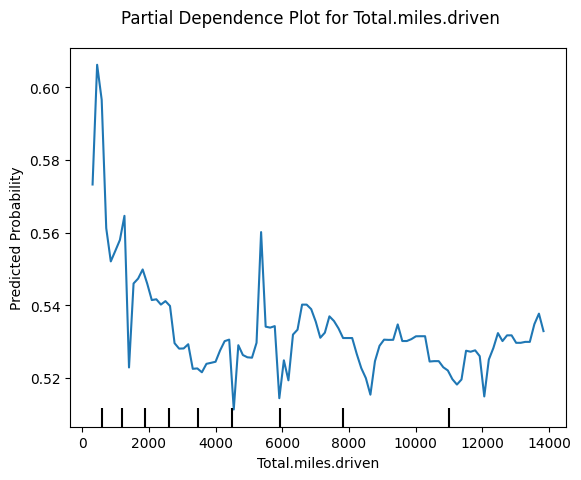

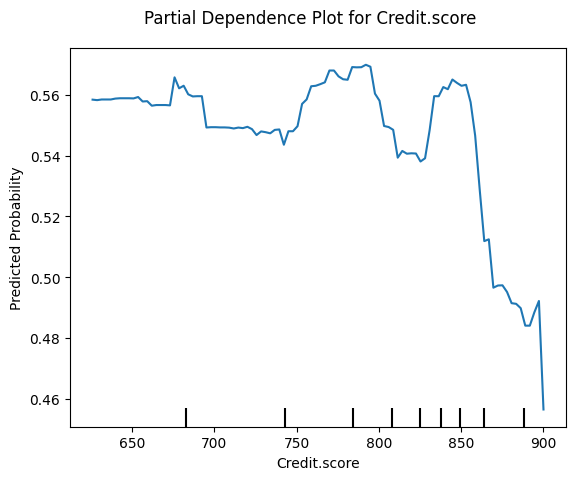

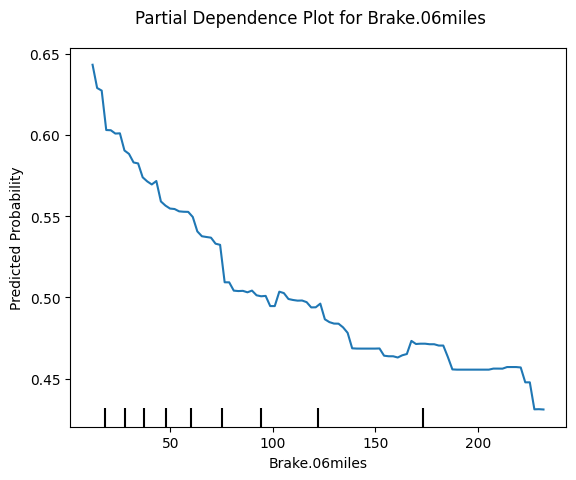

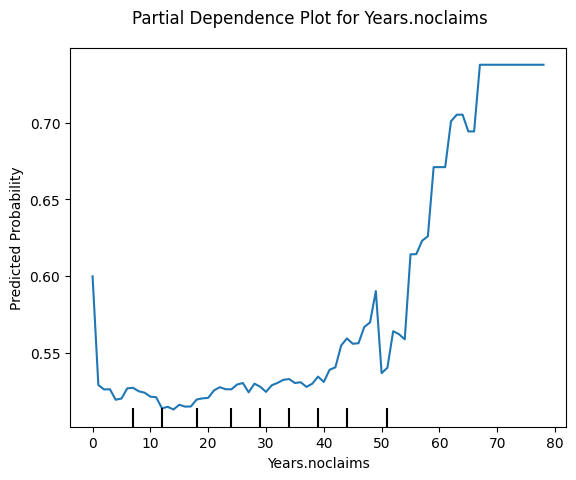

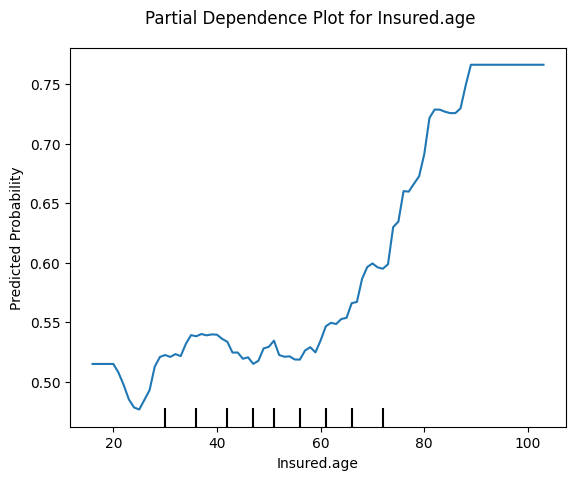

In [192]:
variable = 'Total.miles.driven'

PartialDependenceDisplay.from_estimator(xgb_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Credit.score'

PartialDependenceDisplay.from_estimator(xgb_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Brake.06miles'

PartialDependenceDisplay.from_estimator(xgb_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Years.noclaims'

PartialDependenceDisplay.from_estimator(xgb_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

variable = 'Insured.age'

PartialDependenceDisplay.from_estimator(xgb_model, X_train, [variable])
# Add title and axis labels
plt.subplots_adjust(top=0.9)
plt.suptitle('Partial Dependence Plot for ' + str(variable))
plt.xlabel(str(variable))
plt.ylabel('Predicted Probability')
plt.show()

In [193]:
#Choosen to explain the 50th entry
choosen_instance = X_test.iloc[[50]]

In [194]:
#Creating the Explainer
predict_model = lambda x: xgb_model.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,feature_names = X_train.columns,class_names=['Female','Male'],mode='classification')
exp = explainer.explain_instance(choosen_instance.values[0], predict_model)
exp.show_in_notebook(show_all=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


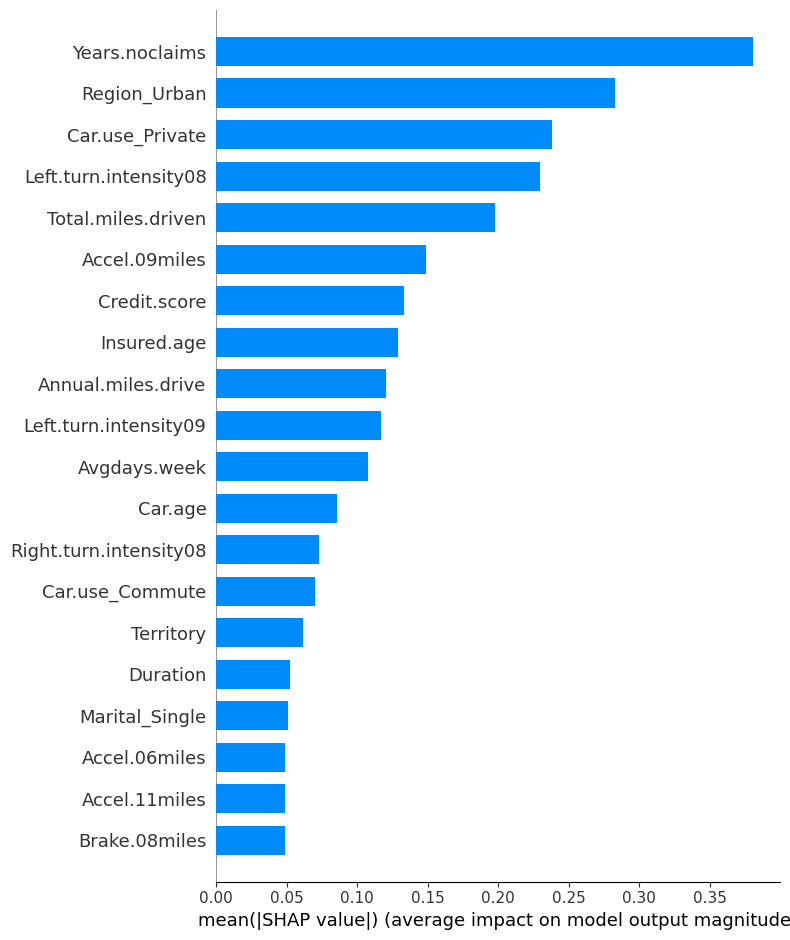

In [195]:
explainer = shap.TreeExplainer(xgb_model,masker=shap.maskers.Impute(data=X_train))
#Using the explainer to explain predictions
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar",class_names=['Female','Male'])